# 1)- Introduction

- The momentum trading strategy consists of creating buying/selling signals based on various time framed sum moving averages (SMA) of an asset's price action or volume (2-days MA, 3-weeks MA, etc..). In general, we follow the momentum of the price action by buying low and selling high.

- Just like the ARIMA notebook, we are going to conduct our data analytics using AAPL stock over this year so far. The financial data is from YahooFinance package.

**PS: The trading volume is the quantity of an asset exchanged within the last 24h, it's generally expressed in dollars.**


In [1]:
!pip install yfinance pandas-ta

     |████████████████████████████████| 115 kB 9.8 MB/s 
     |████████████████████████████████| 6.4 MB 43.7 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=84d2f59ef0a61c862be7c91387f693e43a05ccd2b9c8cdcae601eb33a24c6572
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas_ta as ta

# 2)- How choose the SMA time frame?

- A critical component of a momentum trading strategy is the choice of the right time frame over which we compute our moving averages. This time frame can determine how successful our strategy will be. In my case, I decided to choose a medium sized time frame of 25 days, and then compute the 25-d SMA price action and volume.
- First, let's load our AAPL stock data for the last 200 days from YahooFinance:

In [3]:
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2021-1-1", end=datetime.today().strftime('%Y-%m-%d'), interval="1d")
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,132.701930,132.791375,125.983346,128.617111,143301900,0.0,0
2021-01-05,128.100300,130.932844,127.643112,130.207306,97664900,0.0,0
2021-01-06,126.937458,130.247057,125.605665,125.824318,155088000,0.0,0
2021-01-07,127.573546,130.823515,127.076610,130.117859,109578200,0.0,0
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0


In [4]:
# Dataset shape
df_apple.shape

(247, 7)

- We can see that the dataset contains only 247 samples, instead of 355. This is because weekends and holidays are not accounted for as trading days. Now that we got the data, let's compute the 25-d SMA over close prices and volumes.
- We will also have empty values in the first 24 days of the computed moving averages, since there are not enough data to compute over.

In [5]:
# Let's compute the 5-d, 15-d and 25-d SMA for visualization
df_apple["5d_sma_price"] = df_apple['Close'].rolling(5).mean()
df_apple["15d_sma_price"] = df_apple['Close'].rolling(15).mean()
df_apple["25d_sma_price"] = df_apple['Close'].rolling(25).mean()

# The 25-d SMA for trading volume
df_apple["25d_sma_volume"] = df_apple['Volume'].rolling(25).mean()
df_apple = df_apple[df_apple["25d_sma_price"].notna()]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume
Date,,,,,,,,,,,
2021-02-08,135.398555,136.324246,134.293707,136.274475,71297200,0.0,0,135.246024,135.665579,132.870441,110034488.0
2021-02-09,135.985831,137.239992,135.219416,135.378662,76774200,0.0,0,135.489175,136.221038,133.140903,107373380.0
2021-02-10,135.846472,136.354115,133.776126,134.761536,73046600,0.0,0,135.817612,136.457070,133.323072,106388648.0
2021-02-11,135.269161,135.756892,133.149059,134.502747,64280000,0.0,0,135.408517,136.355161,133.670209,102756328.0
2021-02-12,133.726369,134.900884,133.069429,134.741623,60145100,0.0,0,135.131808,136.123407,133.855160,100779004.0


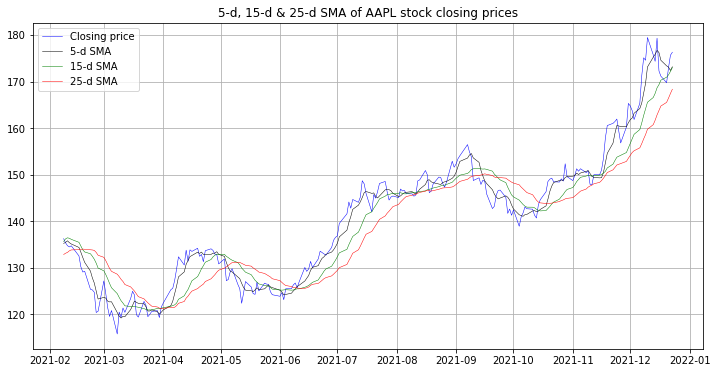

In [6]:
# Let's visualize the SMAs in a graph
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'], color='blue', linewidth=0.5, label='Closing price')
plt.plot(df_apple['5d_sma_price'], color='black', linewidth=0.5, label='5-d SMA')
plt.plot(df_apple['15d_sma_price'], color='green', linewidth=0.5, label='15-d SMA')
plt.plot(df_apple['25d_sma_price'], color='red', linewidth=0.5, label='25-d SMA')
plt.title("5-d, 15-d & 25-d SMA of AAPL stock closing prices")
plt.legend(loc='best')
plt.grid()
plt.show()

# 3)- Creating buy/sell signals

## 3.1)- First strategy: 25-d SMA of price & trading volume



- After computing the 25-d SMAs, we need to establish a strategy based on which we generate a buy or sell signal. The strategy will be as simple as this: when the asset's close price is below the 25-d SMA, and the volume is above the 25-d SMA it's a buying signal, and vice versa for selling.

- Next, we'll create two columns indicating which days are having their 25-d SMA lower than the closing price, and their volume higher than 25-d SMA. We'll also add a variable **buy** that indicates our position in the previous day, so we can only buy if we sold yesterday, and vice versa.

In [7]:
def first_strategy(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['Close'] <= row['25d_sma_price'] and row['Volume'] >= row['25d_sma_volume']:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['Close'] > row['25d_sma_price'] and row['Volume'] < row['25d_sma_volume']:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["sell_signals"], df_apple["buy_signals"] = first_strategy(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume,sell_signals,buy_signals
Date,,,,,,,,,,,,,
2021-02-08,135.398555,136.324246,134.293707,136.274475,71297200,0.0,0,135.246024,135.665579,132.870441,110034488.0,NaN,NaN
2021-02-09,135.985831,137.239992,135.219416,135.378662,76774200,0.0,0,135.489175,136.221038,133.140903,107373380.0,NaN,NaN
2021-02-10,135.846472,136.354115,133.776126,134.761536,73046600,0.0,0,135.817612,136.457070,133.323072,106388648.0,NaN,NaN
2021-02-11,135.269161,135.756892,133.149059,134.502747,64280000,0.0,0,135.408517,136.355161,133.670209,102756328.0,NaN,NaN
2021-02-12,133.726369,134.900884,133.069429,134.741623,60145100,0.0,0,135.131808,136.123407,133.855160,100779004.0,NaN,NaN


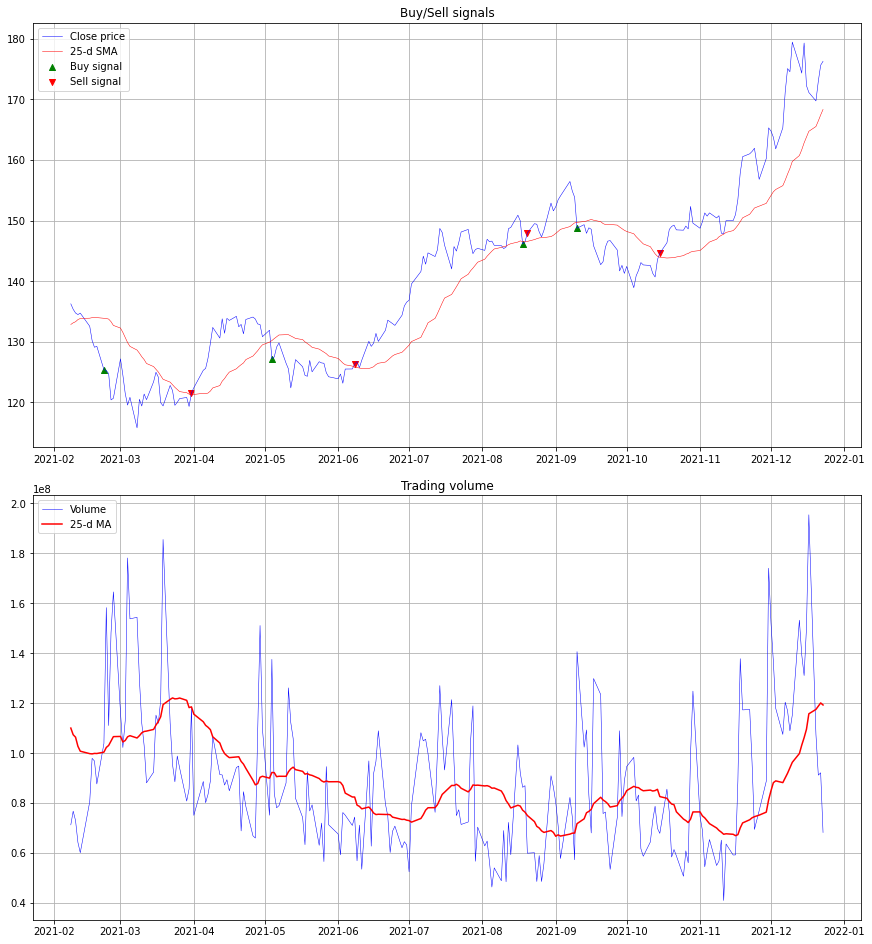

In [8]:
# Let's visualize buying/selling signals in the chart
fig, ax = plt.subplots(2, 1, figsize=(12, 13), constrained_layout=True) 
ax[0].plot(df_apple['Close'] , label='Close price', linewidth=0.5, color='blue')
ax[0].plot(df_apple['25d_sma_price'], color='red', linewidth=0.5, label='25-d SMA')
ax[0].scatter(df_apple.index , df_apple['buy_signals'], label='Buy signal', marker='^', color='green')
ax[0].scatter(df_apple.index , df_apple['sell_signals'] , label='Sell signal' , marker='v', color='red')
ax[0].set_title("Buy/Sell signals")
ax[0].legend(loc='best')
ax[0].grid()

ax[1].plot(df_apple['Volume'] , label='Volume', linewidth=0.5, color='blue')
ax[1].plot(df_apple['25d_sma_volume'], color='red', label='25-d MA')
ax[1].set_title("Trading volume")
ax[1].legend(loc='best')
ax[1].grid()
plt.show()

## 3.2)- Second strategy: Short & long period SMA

- A second strategy would be to create a short period SMA (e.g: 10-d SMA), and a longer one (60-d SMA), and then analyze the crossovers between the two to generate buy/sell signals:

1.   If the short period SMA is below the long period SMA, it means that the trend is going down, so it's a **sell signal**, it's also known as **the death cross**.
2.   Otherwise, the trend is shiftting up, and it's a **buy signal**, it's also called **the golden cross**.





In [87]:
# Let's compute the 10-d, and 60-d SMA
df_apple = aapl.history(start="2021-1-1", end=datetime.today().strftime('%Y-%m-%d'), interval="1d")
df_apple["10d_sma_price"] = df_apple['Close'].rolling(10).mean()
df_apple["60d_sma_price"] = df_apple['Close'].rolling(60).mean()
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,10d_sma_price,60d_sma_price
Date,,,,,,,,,
2021-01-04,132.701914,132.791359,125.983331,128.617096,143301900,0.0,0,NaN,NaN
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN
2021-01-07,127.573531,130.823500,127.076595,130.117844,109578200,0.0,0,NaN,NaN
2021-01-08,131.618582,131.817369,129.432065,131.240921,105158200,0.0,0,NaN,NaN


In [88]:
def second_strategy(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['10d_sma_price'] > row['60d_sma_price']:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['10d_sma_price'] < row['60d_sma_price']:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["sell_signals"], df_apple["buy_signals"] = second_strategy(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,10d_sma_price,60d_sma_price,sell_signals,buy_signals
Date,,,,,,,,,,,
2021-01-04,132.701914,132.791359,125.983331,128.617096,143301900,0.0,0,NaN,NaN,NaN,NaN
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN,NaN,NaN
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN,NaN,NaN
2021-01-07,127.573531,130.823500,127.076595,130.117844,109578200,0.0,0,NaN,NaN,NaN,NaN
2021-01-08,131.618582,131.817369,129.432065,131.240921,105158200,0.0,0,NaN,NaN,NaN,NaN


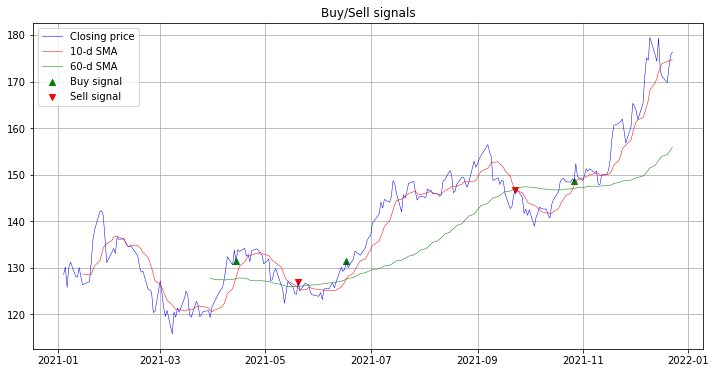

In [89]:
# Let's visualize buying/selling signals in the chart
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'] , label='Closing price', linewidth=0.5, color='blue')
plt.plot(df_apple['10d_sma_price'], color='red', linewidth=0.5, label='10-d SMA')
plt.plot(df_apple['60d_sma_price'], color='green', linewidth=0.5, label='60-d SMA')
plt.scatter(df_apple.index , df_apple['buy_signals'], label='Buy signal', marker='^', color='green')
plt.scatter(df_apple.index , df_apple['sell_signals'] , label='Sell signal' , marker='v', color='red')
plt.title("Buy/Sell signals")
plt.legend(loc='best')
plt.grid()
plt.show()

## 3.3)- Third strategy: The Moving Average Convergence Divergence indicator (MACD)

- **The MACD** is a really famous strategy in algorithmic trading, it's basically a difference between a long term and a short term exponential moving average (EMA). So far, we only covered **SMA** where the mean is computed such as every data point is equally weighted, an **EMA** gives higher weights to recent data points in order to give more importance to recent events in our calculations.

- Now, let's create our main indicators:

1.   Firstly, we'll create the difference between short & long term EMAs called the MACD (We usually take a 26-period EMA for long term, and a 12-period EMA for short term).

2.   Secondly, we'll create an EMA of the MACD itself, which we'll call **The signal** (We usually take a 9-period EMA).

3.   Finally, we'll create a histogram which is basically just the difference between MACD and the signal.



In [9]:
df_apple = aapl.history(start="2021-1-1", end=datetime.today().strftime('%Y-%m-%d'), interval="1d")

In [10]:
df_apple["MACD"] = ta.ema(df_apple["Close"], length=12) - ta.ema(df_apple["Close"], length=26)
df_apple["Signal"] = ta.ema(df_apple["MACD"], length=9)
df_apple["Histogram"] = df_apple["MACD"] - df_apple["Signal"]
df_apple.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal,Histogram
Date,,,,,,,,,,
2021-12-17,169.929993,173.470001,169.690002,171.139999,195432700,0.0,0,5.689722,5.702068,-0.012346
2021-12-20,168.279999,170.580002,167.460007,169.750000,107499100,0.0,0,5.126242,5.586903,-0.460661
2021-12-21,171.559998,173.199997,169.119995,172.990005,91185900,0.0,0,4.884812,5.446484,-0.561673
2021-12-22,173.039993,175.860001,172.149994,175.639999,92135300,0.0,0,4.851386,5.327465,-0.476079
2021-12-23,175.850006,176.850006,175.270004,176.279999,68227500,0.0,0,4.820965,5.226165,-0.405200


- After creating the indicators, the MACD strategy is as simple as this: When MACD line crosses above the signal, it's a buy, otherwise it's a short.

In [11]:
def MACD_strategy(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['MACD'] > row['Signal']:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['MACD'] < row['Signal']:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["macd_sell_signals"], df_apple["macd_buy_signals"] = MACD_strategy(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal,Histogram,macd_sell_signals,macd_buy_signals
Date,,,,,,,,,,,,
2021-01-04,132.701914,132.791359,125.983331,128.617096,143301900,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-07,127.573531,130.823500,127.076595,130.117844,109578200,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-08,131.618582,131.817369,129.432065,131.240921,105158200,0.0,0,NaN,NaN,NaN,NaN,NaN


- Next, we'll create a new column to colour **Histogram** bars in green when the actual histogram value is higher than the previous one, and in red otherwise. 

In [12]:
df_apple["hist_colour"] = ["green" if df_apple.iloc[i]["Histogram"] > df_apple.iloc[i-1]["Histogram"] else "red" for i in range(len(df_apple))]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal,Histogram,macd_sell_signals,macd_buy_signals,hist_colour
Date,,,,,,,,,,,,,
2021-01-04,132.701914,132.791359,125.983331,128.617096,143301900,0.0,0,NaN,NaN,NaN,NaN,NaN,red
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN,NaN,NaN,NaN,red
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN,NaN,NaN,NaN,red
2021-01-07,127.573531,130.823500,127.076595,130.117844,109578200,0.0,0,NaN,NaN,NaN,NaN,NaN,red
2021-01-08,131.618582,131.817369,129.432065,131.240921,105158200,0.0,0,NaN,NaN,NaN,NaN,NaN,red


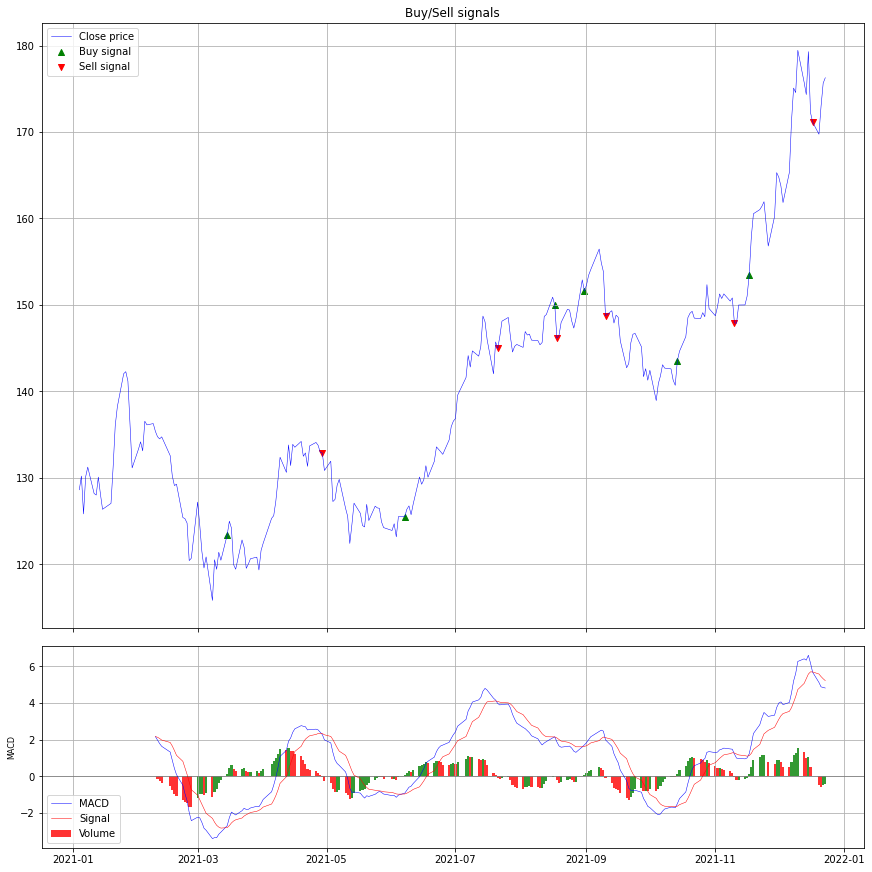

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, constrained_layout=True) 
ax[0].plot(df_apple['Close'] , label='Close price', linewidth=0.5, color='blue')
ax[0].scatter(df_apple.index , df_apple['macd_buy_signals'], label='Buy signal', marker='^', color='green')
ax[0].scatter(df_apple.index , df_apple['macd_sell_signals'] , label='Sell signal' , marker='v', color='red')
ax[0].set_title("Buy/Sell signals")
ax[0].legend(loc='best')
ax[0].grid()

ax[1].plot(df_apple['MACD'], label='MACD', linewidth=0.5, color='blue')
ax[1].plot(df_apple['Signal'], label='Signal', linewidth=0.5, color='red')
ax[1].bar(df_apple.index, df_apple['Histogram'], label='Volume', color=df_apple.hist_colour.map({"green": 'g', "red": 'r'}), width=1, alpha=0.8)
ax[1].axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax[1].legend(loc='best')
ax[1].set_ylabel('MACD', fontsize=8)
ax[1].grid()
plt.show()

## 3.4)- Fourth strategy: Bollinger Bands (BB)

- **The Bollinger Bands strategy (BB)** is a widely used trading indicator, which is simple but immensly profitable. It was invented by **John Bollinger** in the **1980s**, and it's basically generating buy/sell signals based on overbought/oversold areas. It comprises of three main components:

1.   **Middle Bollinger Band (MBB)** which is an n-period SMA of the closing price action (usually we take n=20):

$$
\boxed{MBB(PA,n) = SMA(PA,n)}
$$


2.   **Upper Bollinger Band (UBB)** is a line which is m standard deviations above the **MBB** (usually we take m=2):

$$
\boxed{UBB(PA,n,m) = MBB(PA,n) + m∗\sigma(PA,n)}
$$

3.   **Lower Bollinger Band (LBB)** is a line which is m standard deviations below the **MBB**:

$$
\boxed{LBB(PA,n,m) = MBB(PA,n) - m∗\sigma(PA,n)}
$$

- where PA is the price action. Now, let's compute the above indicators for n=20, and m=2.


In [59]:
df_apple = aapl.history(start="2021-1-1", end=datetime.today().strftime('%Y-%m-%d'), interval="1d")

In [60]:
df_apple["MBB_20d"] = df_apple["Close"].rolling(20).mean()
std_20d = df_apple["Close"].rolling(20).std() 
df_apple["UBB_20d_2.0"] = df_apple["MBB_20d"] + 2.0 * std_20d
df_apple["LBB_20d_2.0"] = df_apple["MBB_20d"] - 2.0 * std_20d
df_apple.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MBB_20d,UBB_20d_2.0,LBB_20d_2.0
Date,,,,,,,,,,
2021-12-17,169.929993,173.470001,169.690002,171.139999,195432700,0.0,0,167.800001,181.866648,153.733353
2021-12-20,168.279999,170.580002,167.460007,169.750000,107499100,0.0,0,168.260001,181.924347,154.595654
2021-12-21,171.559998,173.199997,169.119995,172.990005,91185900,0.0,0,168.858501,182.233140,155.483862
2021-12-22,173.039993,175.860001,172.149994,175.639999,92135300,0.0,0,169.570000,182.789353,156.350648
2021-12-23,175.850006,176.850006,175.270004,176.279999,68227500,0.0,0,170.287000,183.318089,157.255912


- Let's implement the **BB** strategy: when the **Close price** goes below the **LBB**, we are taking a long position, and if the **Close price** crosses above the **UBB** we are taking a short position.

In [61]:
def BB_strategy(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['Close'] < row['LBB_20d_2.0']:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['Close'] > row['UBB_20d_2.0']:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["bb_sell_signals"], df_apple["bb_buy_signals"] = BB_strategy(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MBB_20d,UBB_20d_2.0,LBB_20d_2.0,bb_sell_signals,bb_buy_signals
Date,,,,,,,,,,,,
2021-01-04,132.701930,132.791375,125.983346,128.617111,143301900,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-07,127.573531,130.823500,127.076595,130.117844,109578200,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0,NaN,NaN,NaN,NaN,NaN


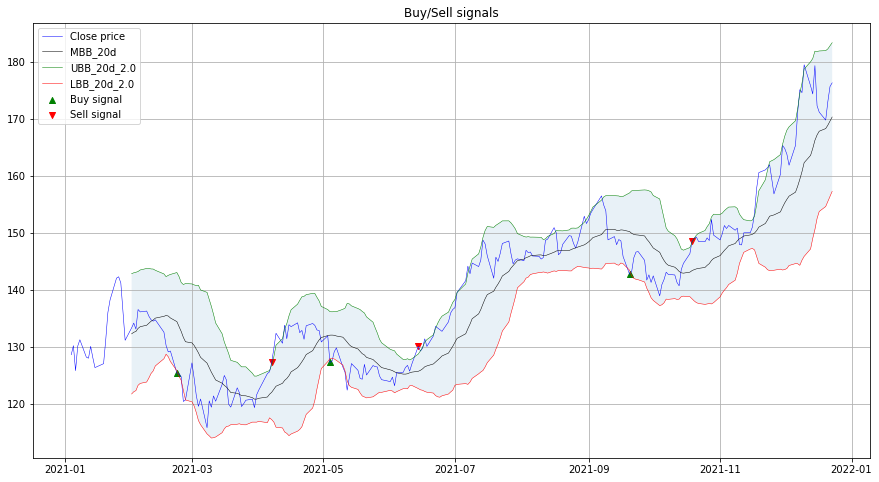

In [69]:
plt.figure(figsize=(15, 8))
plt.plot(df_apple['Close'] , label='Close price', linewidth=0.5, color='blue')
plt.plot(df_apple['MBB_20d'], label='MBB_20d', linewidth=0.5, color='black')
plt.plot(df_apple['UBB_20d_2.0'], label='UBB_20d_2.0', linewidth=0.5, color='green')
plt.plot(df_apple['LBB_20d_2.0'], label='LBB_20d_2.0', linewidth=0.5, color='red')
plt.fill_between(df_apple.index, df_apple['LBB_20d_2.0'], df_apple['UBB_20d_2.0'], alpha=0.1)
plt.scatter(df_apple.index , df_apple['bb_buy_signals'], label='Buy signal', marker='^', color='green')
plt.scatter(df_apple.index , df_apple['bb_sell_signals'] , label='Sell signal' , marker='v', color='red')
plt.title("Buy/Sell signals")
plt.legend(loc='best')
plt.grid()
plt.show()